# Train Agent on Unity Environment

---

## Start the Environment

Below assumes that one has followed the instruction on the README file such that the Unity environment is ready.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


## Background

The algorithm used is based on [Deep Deterministic Policy Gradients (DDPG)](https://arxiv.org/abs/1509.02971). Specifically, it is a distributed version of the algorithm referred to as D3PG which is mentioned [here](https://openreview.net/forum?id=SyZipzbCb). 

In the aforementioned paper, it is referred to as an "Actor-Critic" method which involves an "Actor" which acts as a policy network and a "Critic" which acts as a value network. The "Actor" chooses an action given a state and the "Critic" informs the "Actor" which action in a given state should have its probability of occurring increased because it leads to a high reward and vice versa.

The hyperparameters are mostly inspired by the first [paper](https://arxiv.org/abs/1509.02971):

|Hyperparameters|Value|
|---|---|
|Replay Buffer size|1e6|
|Batch size|128|
|Discount factor (gamma)|0.99|
|Soft update parameter (tau)|1e-3|
|Actor learning rate|1e-5|
|Critic learning rate|1e-5|
|Weight decay|0|
|Ornstein-Uhlenbeck theta|0.15|
|Ornstein-Uhlenbeck sigma|0.2|
|Number of layers|2|
|Number of units for first hidden layer|400|
|Number of units for second hidden layer|300|

with the exception of the batch size and learning rates which were obtained through hyperparameter search.

Batch sizes of 32, 64, 128, 256, 512, and 1024 were tested and 128 performed the best.

Learning rates of 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, and 1e-6 were tested for both the "Actor" and "Critic" networks and 1e-5 performed the best.

Lastly, weight decay of 1e-2 as used in the first paper significantly slowed down learning, and thus the weight decay was set to 0.

The network architecture for both the "Actor" and "Critic" is based on the one from the first paper. It consists of two hidden fully-connected layers with 400 and 300 units, respectively. The action is used as an input to the second hidden layer of the "Critic". The tanh activation function is used for the output layer of the "Actor" to bound the value between -1 and 1. ReLU  is used in all other hidden layers. Lastly, batch normalization is applied to the state input and all layers in "Actor" and all layers prior to the action input in "Critic" such that it has a norm of 1.

Both agents share the "Actor", "Critic" and the replay buffer.

Ornstein-Uhlenbeck process is used to help with temporally correlated exploration. The implementation is borrowed from Udacity's [implementation](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py). However, during experimentation, it was discovered that the use of random number from a uniform distribution `random.random()` was harmful to learning. The use of random number from a normal distribution, on the other hand, allowed for fast learning convergence.

Initially the agents could not learn to achieve a score of 0.1 averaged over 100 consecutive episodes due to each agent lacking information about each other's observation and action. [OpenAI's paper](https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf) states that the problem is due to the non-stationarity of the environment from the perspective of each agent. To solve this, the paper suggests using a centralized "Critic" that takes all agents' observations and actions which allow the "Critic" to learn the relationship between all agents. During testing, each agent only uses its own observation to decide what action to take.

During training, it was discovered that the agents took a very long time getting stuck with an average score of 0.3. This was most likely due to exploration noise that prevented the agents from exploiting their shared policy. By introducing an exploration noise annealing, the agents were able to exploit their shared policy after they sufficiently learned a good policy.

## Initialization

Initialize the agent.

In [5]:
from maddpg import Controller

seed = 69

# initialize the algorithm controller
controller = Controller(state_size, action_size, seed)

Define the training function.

In [6]:
import time
from collections import deque
import torch

def train_agent(env, 
                brain_name, 
                n_episodes=2000, 
                n_timesteps=1000, 
                print_every_n_episode=100,
                save_every_n_episode=100,
                learn_every_n_timestep=2,
                n_learning=2,
                passing_score=0.5, 
                actor_model_path="actor.pt",
                critic_model_path="critic.pt"):
    
    has_reached_target_score = False
    
    # initialize start time
    start_time = time.time()
    
    # initialize score trackers
    scores = []
    average_scores = []
    scores_deque = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        
        # initialize agent scores (one for each agent)
        agent_scores = np.zeros(num_agents)
        
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # reset the controller
        controller.reset()

        # get the current states (one for each agent)
        states = env_info.vector_observations
        
        for timestep in range(n_timesteps):
            # select actions (one for each agent)
            actions = controller.act(states)
                
            # send actions to the environment
            env_info = env.step(actions)[brain_name]
            
            # get next states
            next_states = env_info.vector_observations
            
            # get rewards
            rewards = env_info.rewards
            
            # get indicators if any episode finishes
            dones = env_info.local_done
            
            # get other states by swapping both agents' states
            other_states = np.stack([states[1], states[0]])
            
            # get other next states by swapping both agents' next states
            other_next_states = np.stack([next_states[1], next_states[0]])
            
            # get other actions by swapping both agents' actions
            other_actions = np.stack([actions[1], actions[0]])
            
            # save experiences collected by agents
            controller.save_experience(states, other_states, actions, other_actions, rewards, next_states, other_next_states, dones)
                
            # learn m times every n timestep
            if (timestep + 1) % learn_every_n_timestep == 0:
                controller.learn(n_learning)
            
            # accumulate rewards for each agent
            agent_scores += rewards
            
            # roll over to the next states
            states = next_states
            
            # exit loop if any of the episodes finishes
            if np.any(dones):
                break
        
        # get max score over agents and add it to the score lists
        max_score_over_agents = np.amax(agent_scores)
        scores.append(max_score_over_agents)
        scores_deque.append(max_score_over_agents)
        average_score_over_100_episodes = np.mean(scores_deque)
        average_scores.append(average_score_over_100_episodes)
        
        # print results
        print("\rEpisode {:4d}/{} \t Current score: {:2.4f} | Avg score over 100 episodes: {:2.4f}".format(i_episode, n_episodes, max_score_over_agents, average_score_over_100_episodes), end="")
        
        if i_episode % print_every_n_episode == 0:
            print("\rEpisode {:4d}/{} \t Current score: {:2.4f} | Avg score over 100 episodes: {:2.4f}".format(i_episode, n_episodes, max_score_over_agents, average_score_over_100_episodes))
            
            minutes, seconds = utils.get_minutes_and_seconds_from_start_time(start_time)
            print("Elapsed time: {:3d} minutes {:2d} seconds\n".format(minutes, seconds))
            
        if i_episode % save_every_n_episode == 0:
            # save models
            torch.save(controller.actor_local.state_dict(), actor_model_path)
            torch.save(controller.critic_local.state_dict(), critic_model_path)
        
        if not has_reached_target_score and average_score_over_100_episodes >= passing_score:
            has_reached_target_score = True
            
            print("\rThe environment is solved in {} episodes with an average score of {:2.4f} over 100 episodes".format(i_episode, average_score_over_100_episodes))
            
            minutes, seconds = utils.get_minutes_and_seconds_from_start_time(start_time)
            print("Elapsed time: {:3d} minutes {:2d} seconds\n".format(minutes, seconds))
    
    return scores, average_scores

## Training

In [7]:
import utils
from workspace_utils import active_session

In [8]:
with active_session():
    scores, average_scores = train_agent(env, 
                        brain_name, 
                        n_episodes=2100,
                        n_timesteps=1000, 
                        print_every_n_episode=100,
                        save_every_n_episode=100,
                        learn_every_n_timestep=2,
                        n_learning=2,
                        passing_score=0.5)

Episode  100/2100 	 Current score: 0.0900 | Avg score over 100 episodes: 0.0076
Elapsed time:   0 minutes 29 seconds

Episode  200/2100 	 Current score: 0.0000 | Avg score over 100 episodes: 0.0274
Elapsed time:   1 minutes  7 seconds

Episode  300/2100 	 Current score: 0.0000 | Avg score over 100 episodes: 0.0365
Elapsed time:   1 minutes 47 seconds

Episode  400/2100 	 Current score: 0.0000 | Avg score over 100 episodes: 0.0457
Elapsed time:   2 minutes 29 seconds

Episode  500/2100 	 Current score: 0.0900 | Avg score over 100 episodes: 0.0114
Elapsed time:   3 minutes  0 seconds

Episode  600/2100 	 Current score: 0.0900 | Avg score over 100 episodes: 0.0330
Elapsed time:   3 minutes 37 seconds

Episode  700/2100 	 Current score: 0.0900 | Avg score over 100 episodes: 0.0774
Elapsed time:   4 minutes 29 seconds

Episode  800/2100 	 Current score: 0.0000 | Avg score over 100 episodes: 0.0549
Elapsed time:   5 minutes 17 seconds

Episode  900/2100 	 Current score: 0.0000 | Avg score ov

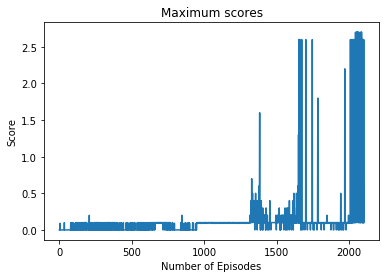

In [9]:
utils.plot_scores(scores, "Maximum scores")

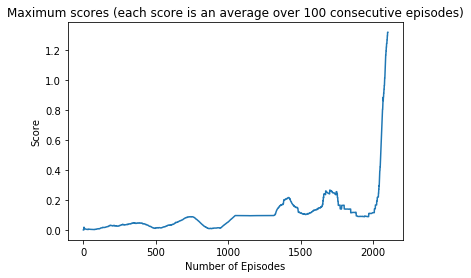

In [10]:
utils.plot_scores(average_scores, "Maximum scores (each score is an average over 100 consecutive episodes)")

## Future Work

Currently the training is not stable within the first 1900 episodes most likely due to suboptimal exploration and exploitation balance. Finding a more stable balance would be an interesting future work.

Also, one can experiment with a model that uses a single network that outputs both the action probability distribution as well as the state value.